# Unsupervised classification with SOM

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from helpers import undersampling
from helpers import show_target_pred_dif
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from configparser import ConfigParser

Wczytyujemy dane z pliku config.ini

In [2]:
config = ConfigParser()
config.read('config.ini')
x_size = int(config['main']['x_size'])
y_size = int(config['main']['y_size'])
clases_names = list(config['classes'].values())
nr_of_classes = len(clases_names)
csv_data_file = config['main']['csv_data_file']

### Preprocessing

In [3]:
df = pd.read_csv(csv_data_file)
X = df.iloc[:,1:-nr_of_classes].to_numpy()
Y = df.iloc[:,-nr_of_classes:].to_numpy()

Feature scaling
$$x = \frac{\overline{x} - x}{\sigma_{x}}$$

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [5]:
from helpers import IoU

In [6]:
from helpers import metrics_matrix

### Training

In [7]:
from minisom import MiniSom
x_som, y_som = 4,4
som = MiniSom(x=x_som, y=y_som, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration=100000, verbose=False)

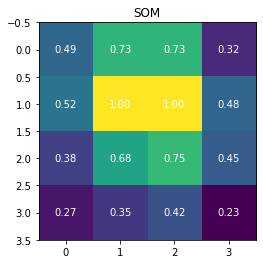

In [8]:
#ax.colorbar()
fig, ax = plt.subplots()
ax.set_title('SOM')
plt.imshow(som.distance_map())
for (i, j), z in np.ndenumerate(som.distance_map()):
    if z > 0.10:
        ax.text(j, i, '{:0.2f}'.format(som.distance_map()[i,j]), ha='center', va='center',color = 'white')

### Predictions

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_pred = [som.winner(x) for x in X]
y_pred = np.array([i[0]*100 + i[1] for i in y_pred ])
y_pred = enc.fit_transform(y_pred.reshape(-1, 1)).toarray()

### Evaluation

In [10]:
cm = confusion_matrix(Y.argmax(axis=1), y_pred.argmax(axis=1))

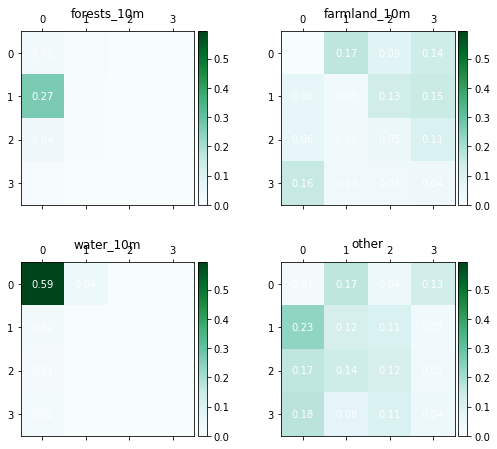

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(figsize=(8,6), ncols = 2, nrows=2)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.4)
vmax = np.max(cm)/(0.25*len(y_pred))
for i, ax in enumerate(axs.flatten()):
    data = cm[i,:].reshape((x_som,y_som))/(0.25*len(y_pred))
    subplot = ax.matshow(data,vmin=0, vmax=vmax, cmap='BuGn')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title(df.columns[-4+i])
    for (i, j), z in np.ndenumerate(data):
        if(z>0.01):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color = 'white')
    fig.colorbar(subplot, cax=cax)

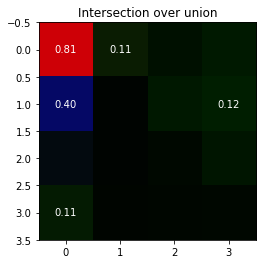

In [12]:
clusstered = np.zeros((x_som,y_som,3))
metrix_IoU = metrics_matrix(Y, y_pred, IoU)
clusstered[...,2]=metrix_IoU[:,0].reshape((x_som,y_som))
clusstered[...,1]=metrix_IoU[:,1].reshape((x_som,y_som))
clusstered[...,0]=metrix_IoU[:,2].reshape((x_som,y_som))
fig, ax = plt.subplots()
ax.set_title('Intersection over union')
plt.imshow(clusstered)
for (i, j, k), z in np.ndenumerate(clusstered):
    if z > 0.10:
        ax.text(j, i, '{:0.2f}'.format(max(clusstered[i,j,:])), ha='center', va='center',color = 'white')


In [13]:
best_3 = [metrix_IoU[:,i].argsort()[-3:][::-1] for i in range(3)]
enc = OneHotEncoder()
y_pred = [som.winner(x) for x in X]
y_pred = np.array([i[0]*100 + i[1] for i in y_pred ])
y_pred = enc.fit_transform(y_pred.reshape(-1, 1)).toarray()

In [14]:
Y_present = y_pred.reshape((x_size,y_size,y_pred.shape[1]))

In [15]:
best_1 = [best_3[i][0] for i in range(3)]

In [16]:
y_target = Y[...,:-1].reshape((x_size,y_size,3))
y_pred = Y_present[...,best_1]

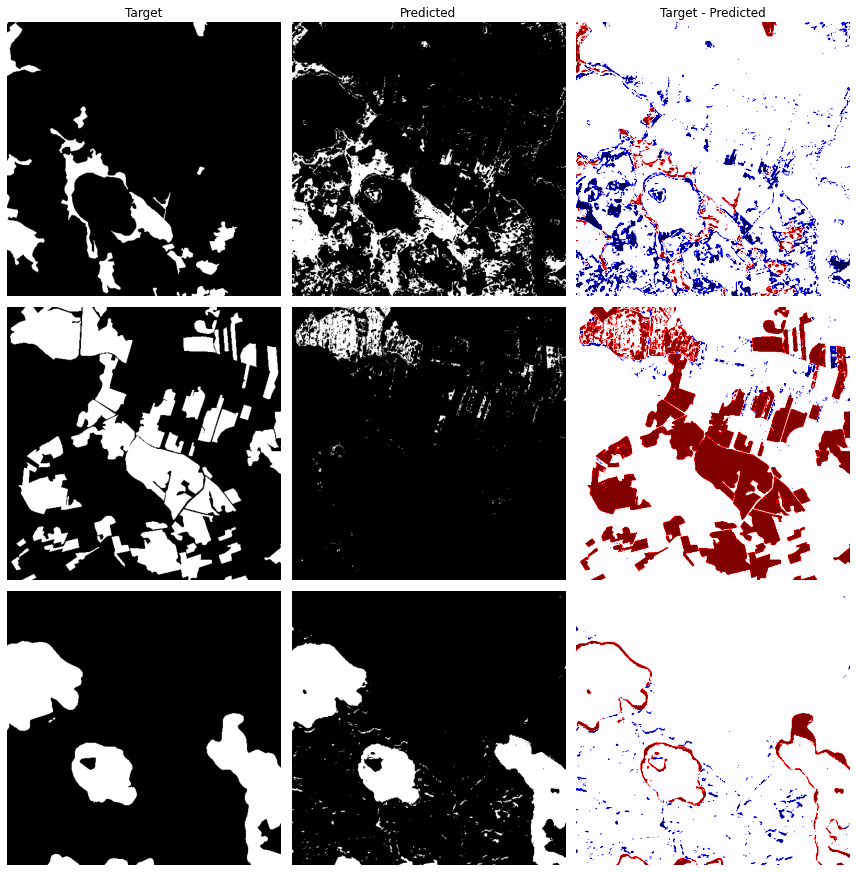

In [17]:
show_target_pred_dif(y_target,y_pred)